# Shakespeare & Company Analysis

---

https://shakespeareandco.princeton.edu/

In 1919, an American woman named Sylvia Beach (1887 – 1962) opened an English-language bookshop and lending library on the Left Bank in Paris. She called it Shakespeare and Company, and it quickly became the center of expatriate life in the city. In 1922, she published James Joyce’s Ulysses under the Shakespeare and Company imprint, making the bookshop and lending library famous around the world. Over the next two decades, she sold and loaned books—everything from the avant-garde poetry to birth control manuals to the latest philosophy. In 1941, she closed the bookshop and lending library during the German occupation of France. Shakespeare and Company would never reopen, but she continued to loan books from her apartment until her death.

The Shakespeare and Company Project uses the records of Sylvia Beach’s famous bookshop and lending library to reveal the reading practices of many of the century’s most influential writers, along with hundreds of other artists, intellectuals, and students who lived in Paris between the two world wars.

---

Reading in necessary libraries and modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

Reading in books.csv, setting the encoding to utf-8, setting the type for the year column.

In [2]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})

The empty cells in the format column are filled in with 'Unknown.' The overall inventory of Shakespeare & Company is then illustrated by counting the items in each category (format column). 

In [3]:
di_data = books['format'].fillna('Unknown')
counts = di_data.value_counts()
print(counts)

Book                 5512
Unknown               410
Periodical             93
Photograph              2
Phonograph Record       1
Article                 1
Prints                  1
Name: format, dtype: int64


Visualization of the overall inventory of Shakespeare & Company via matplotlib.

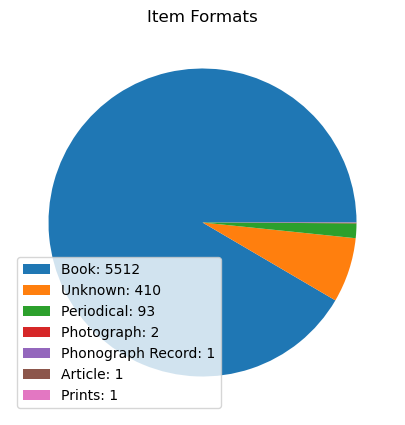

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

ax.pie(counts)
ax.set_title('Item Formats')

legend_labels = [f'{counts.index[i]}: {counts.values[i]}' for i in range(len(counts))]
plt.legend(legend_labels, loc='lower left')
plt.show()

top 15 items purchased / borrowed

In [5]:
tb_data = books[books['format'] == 'Book'][['title','borrow_count','format']].nlargest(15,'borrow_count')
tp_data = books[books['format'] == 'Book'][['title','purchase_count','format']].nlargest(15,'purchase_count')

def plot_barh(title, x_label, y_label, data, column, color):
    plt.figure(figsize=(7,4))
    plt.barh(data[column], data[x_label], color=color)
    # declare count on bar
    for i, v in enumerate(data[x_label]):
        plt.text(v + 0.3, i, str(v), color='black', fontsize=8, va='center')
    plt.subplots_adjust(left=0.4, right=0.95, top=0.95, bottom=0.1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(which='major', color='silver', linewidth=0.4, alpha=0.4)
    plt.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.3, alpha=0.3)
    plt.minorticks_on()
    plt.show()

In [6]:
tb_data_aut = books[books['format'] == 'Book'][['title','borrow_count','format','author']].nlargest(15,'borrow_count')
tp_data_aut = books[books['format'] == 'Book'][['title','purchase_count','format','author']].nlargest(15,'purchase_count')

def plot_barh_aut(title, x_label, y_label, data, column, color):
    plt.figure(figsize=(7,4))
    plt.barh(data[column].astype(str), data[x_label], color=color)
    # declare count on bar
    for i, v in enumerate(data[x_label]):
        plt.text(v + 0.3, i, str(v), color='black', fontsize=8, va='center')
    plt.subplots_adjust(left=0.4, right=0.95, top=0.95, bottom=0.1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(which='major', color='silver', linewidth=0.4, alpha=0.4)
    plt.grid(which='minor', color='whitesmoke', linestyle=':', linewidth=0.3, alpha=0.3)
    plt.minorticks_on()
    plt.show()

Call plot_barh function, illustrating the top 15 most borrowed items.

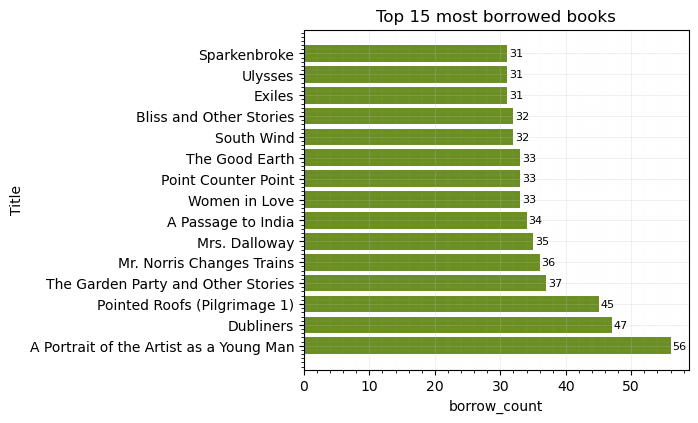

In [7]:
plot_barh('Top 15 most borrowed books', 'borrow_count', 'Title', tb_data, 'title', 'olivedrab')

Call plot_barh function, illustrating the top 15 most purchased items. Instead of borrow_count, we now access the purchase_count column.

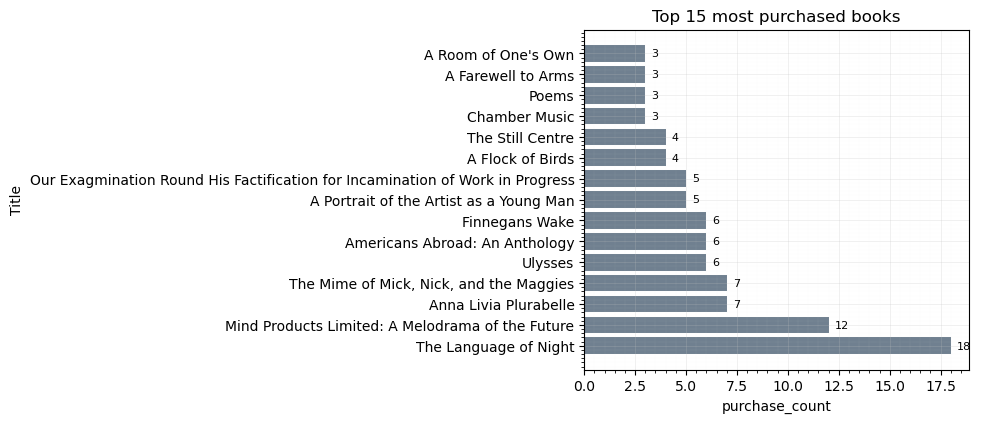

In [8]:
plot_barh('Top 15 most purchased books', 'purchase_count', 'Title', tp_data, 'title', 'slategrey')

The filter_events function already includes the reading of events.csv. 

In [9]:
def filter_events(event_type, author_name=None):
    df = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8', low_memory=False)
    df = df[['start_date', 'event_type', 'item_authors']].dropna()
    df['start_date'] = df['start_date'].str.replace('\D+', '', regex=True).str[:4].astype(int)
    # I chose to filter with <= 1941 because the bookstore officially closed in 1941. After this they ocassionally sold or lend books but the bookstore itself didn't exist anymore
    df =  df[(df['start_date'].astype(str).str.match('^19[1-4]\d$')) & (df['start_date'] <= 1941)]
    df = df.loc[df['event_type'] == event_type]
    # in case it should be filtered by author
    if author_name is not None:
        df = df[df['item_authors'].astype(str).str.match(author_name)]
    df['start_date'] = pd.to_datetime(df['start_date'], format='%Y')
    count = df['start_date'].dt.year.value_counts()
    count = count.sort_index()
    return count

Using the filter_events function on the borrow and purchase count, respectively.

In [10]:
b_count = filter_events('Borrow')
p_count = filter_events('Purchase')

Visualization of the borrow and purchase history from 1919 to 1941.

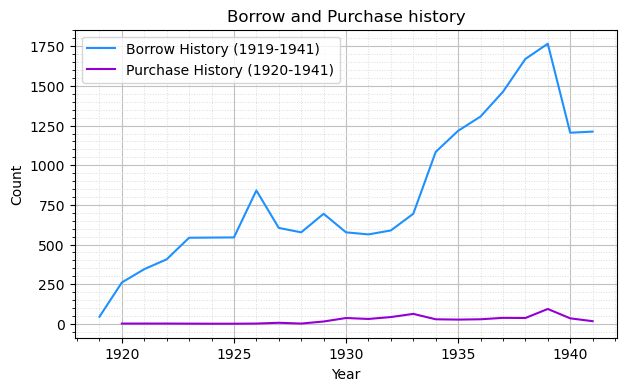

In [11]:
plt.figure(figsize=(7,4))

plt.plot(b_count.index, b_count.values, label='Borrow History (1919-1941)', color='dodgerblue')
plt.plot(p_count.index, p_count.values, label='Purchase History (1920-1941)', color='darkviolet')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Borrow and Purchase history')
plt.legend()
plt.grid(which='major', color='silver', linewidth=0.8)
plt.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.7)
plt.minorticks_on()
plt.show()

Top books by specific authors



In [12]:
def author_items(author):
    df = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8', low_memory=False)
    df = df[['start_date', 'event_type', 'item_authors', 'item_title']].dropna()
    df['start_date'] = df['start_date'].str.replace('\D+', '', regex=True).str[:4].astype(int)
    borrow =  df[(df['start_date'].astype(str).str.match('^19[1-4]\d$')) & (df['start_date'] <= 1941)] 
    borrow = borrow[(borrow['item_authors'].astype(str).str.match(author)) & borrow['event_type'].astype(str).str.match('^Borrow$')]
    item_counts = borrow[['event_type', 'item_title']].groupby('item_title').count()
    item_counts.columns = ['borrow_count']
    item_counts = item_counts.sort_values(by='borrow_count')
    item_counts = item_counts.reset_index()
    return item_counts

eh_borrow = author_items('^Hemingway, Ernest$')
vw_borrow = author_items('^Woolf, Virginia$')
wf_borrow = author_items('^Faulkner, William$')

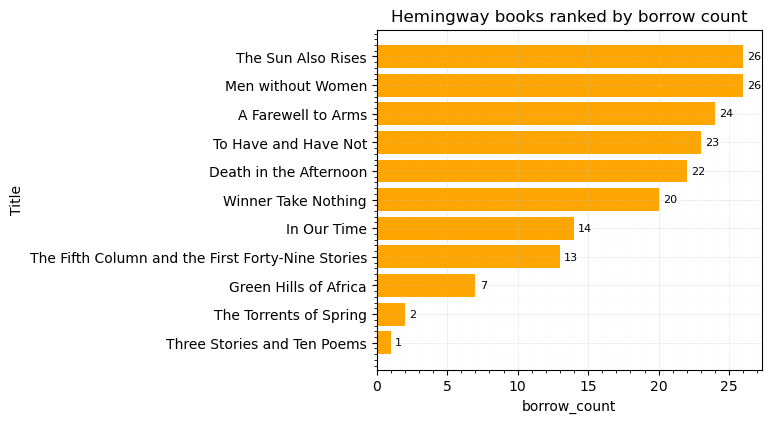

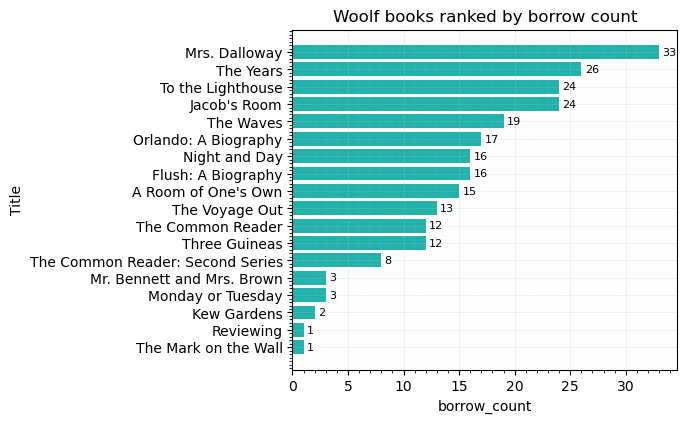

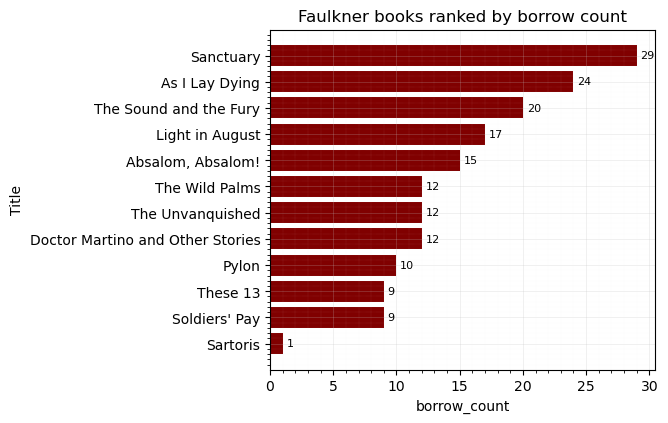

In [13]:
plot_barh('Hemingway books ranked by borrow count', 'borrow_count', 'Title', eh_borrow, 'item_title', 'orange')
plot_barh('Woolf books ranked by borrow count', 'borrow_count', 'Title', vw_borrow, 'item_title', 'lightseagreen')
plot_barh('Faulkner books ranked by borrow count', 'borrow_count', 'Title', wf_borrow, 'item_title', 'maroon')

comparison between 4 authors

In [14]:
dhl_count = filter_events('Borrow','Lawrence, D. H.')
vw_count = filter_events('Borrow','Woolf, Virginia')
eh_count = filter_events('Borrow','Hemingway, Ernest')
jj_count = filter_events('Borrow','Joyce, James')

Visualization

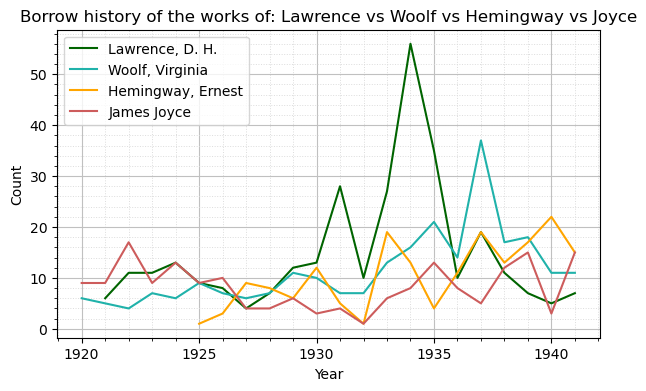

In [15]:
plt.figure(figsize=(7,4))
plt.plot(dhl_count.index, dhl_count.values, label='Lawrence, D. H.', color='darkgreen')
plt.plot(vw_count.index, vw_count.values, label='Woolf, Virginia', color='lightseagreen')
plt.plot(eh_count.index, eh_count.values, label='Hemingway, Ernest', color='orange')
plt.plot(jj_count.index, jj_count.values, label='James Joyce', color='indianred')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Borrow history of the works of: Lawrence vs Woolf vs Hemingway vs Joyce')
plt.legend()
plt.grid(which='major', color='silver', linewidth=0.8)
plt.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.7)
plt.minorticks_on()
plt.show()